# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita una versión > 3.5.1 que soporte float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00
time: 517 µs (started: 2023-02-25 12:22:13 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.84 s (started: 2023-02-25 12:22:13 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/regular_otsu/

versión Keras: 2.11.0
time: 1.23 ms (started: 2023-02-25 12:22:17 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 25 s (started: 2023-02-25 12:22:17 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_9G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name, like DenseNet121.
    ''' 
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)

    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.08 ms (started: 2023-02-25 12:22:42 +00:00)


# Imgs 64x64

- Test Accuracy: 0.568263053894043
- Test Loss: 2.2217161655426025
- time: 3h 52min 36s
- F1 score: 0.5692912916196161
- Precision score: 0.5966580395243624
- Recall:  0.5682630691399663
- Epoch: 50/50



## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/regular_otsu/
time: 1.1 ms (started: 2023-02-25 12:23:10 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 18.6 s (started: 2023-02-25 12:23:11 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.28 ms (started: 2023-02-25 12:23:30 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 2s 0us/step
time: 10.2 s (started: 2023-02-25 12:23:30 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 299s 20ms/step - loss: 6.2655 - sparse_categorical_accuracy: 0.0913 - val_loss: 5.3887 - val_sparse_categorical_accuracy: 0.1721
Epoch 2/50
13899/13899 [==============================] - 283s 20ms/step - loss: 4.8133 - sparse_categorical_accuracy: 0.2444 - val_loss: 4.5788 - val_sparse_categorical_accuracy: 0.2650
Epoch 3/50
13899/13899 [==============================] - 281s 20ms/step - loss: 4.1043 - sparse_categorical_accuracy: 0.3332 - val_loss: 4.0924 - val_sparse_categorical_accuracy: 0.3202
Epoch 4/50
13899/13899 [==============================] - 282s 20ms/step - loss: 3.6355 - sparse_categorical_accuracy: 0.3937 - val_loss: 3.7575 - val_sparse_categorical_accuracy: 0.3613
Epoch 5/50
13899/13899 [==============================] - 281s 20ms/step - loss: 3.2939 - sparse_categorical_accuracy: 0.4378 - val_loss: 3.5133 - val_sparse_categorical_accuracy: 0.3907
Epoch 6/50
13899/13899 [==============================] - 283s 20

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.92 s (started: 2023-02-25 16:16:18 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 31s 15ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.568263053894043
- Test Loss: 2.2217161655426025
- time: 
- F1 score: 0.5692912916196161
- Precision score: 0.5966580395243624
- Recall:  0.5682630691399663
- Epoch: 
*********************************************************************************************************************************
time: 1min 4s (started: 2023-02-25 16:16:21 +00:00)


## Graficando

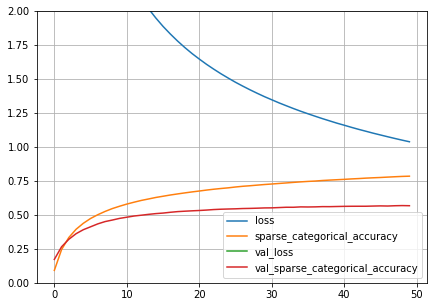

time: 331 ms (started: 2023-02-25 16:17:25 +00:00)


In [ ]:
plot_loss(history)

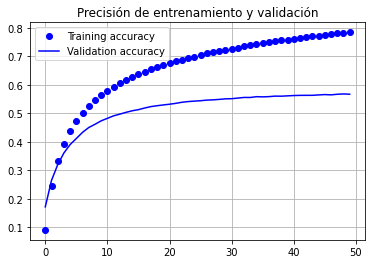

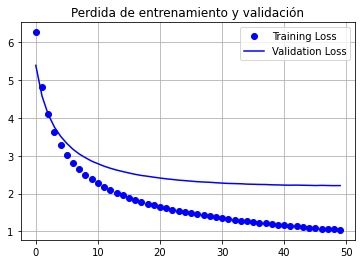

time: 245 ms (started: 2023-02-25 16:17:25 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl9_imgs64_regular__OTSU.h5
time: 4.13 s (started: 2023-02-25 16:17:26 +00:00)


# Imgs 96x96

- Test Accuracy: 0.637015163898468
- Test Loss: 1.843078374862671
- time: 4h 10min 36s
- F1 score: 0.6373325404932062
- Precision score: 0.659306023880548
- Recall:  0.6370151770657673
- Epoch: 50/50



## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/regular_otsu/
time: 841 µs (started: 2023-02-25 16:17:32 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 21 s (started: 2023-02-25 16:17:32 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.22 ms (started: 2023-02-25 16:17:53 +00:00)


## Preparar el modelo

In [ ]:
custom_model2 = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.99 s (started: 2023-02-25 16:17:53 +00:00)


In [ ]:
print(custom_model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['concatenate_1[0][0]']          
 D)                                                                                         

## Entrenar modelo

In [25]:
history2 = train_model(custom_model2, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 302s 21ms/step - loss: 6.1086 - sparse_categorical_accuracy: 0.1188 - val_loss: 5.1538 - val_sparse_categorical_accuracy: 0.2163
Epoch 2/50
13899/13899 [==============================] - 292s 21ms/step - loss: 4.5532 - sparse_categorical_accuracy: 0.2979 - val_loss: 4.2858 - val_sparse_categorical_accuracy: 0.3175
Epoch 3/50
13899/13899 [==============================] - 293s 21ms/step - loss: 3.8152 - sparse_categorical_accuracy: 0.3928 - val_loss: 3.7745 - val_sparse_categorical_accuracy: 0.3804
Epoch 4/50
13899/13899 [==============================] - 299s 22ms/step - loss: 3.3359 - sparse_categorical_accuracy: 0.4560 - val_loss: 3.4240 - val_sparse_categorical_accuracy: 0.4236
Epoch 5/50
13899/13899 [==============================] - 297s 21ms/step - loss: 2.9928 - sparse_categorical_accuracy: 0.5011 - val_loss: 3.1742 - val_sparse_categorical_accuracy: 0.4519
Epoch 6/50
13899/13899 [==============================] - 298s 21

In [26]:
test_images2, test_labels2 = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.91 s (started: 2023-02-25 20:28:35 +00:00)


In [27]:
show_metrics(custom_model2, test_images2, test_labels2)

1854/1854 [==============================] - 33s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.637015163898468
- Test Loss: 1.843078374862671
- time: 
- F1 score: 0.6373325404932062
- Precision score: 0.659306023880548
- Recall:  0.6370151770657673
- Epoch: 
*********************************************************************************************************************************
time: 1min 7s (started: 2023-02-25 20:28:38 +00:00)


## Graficando

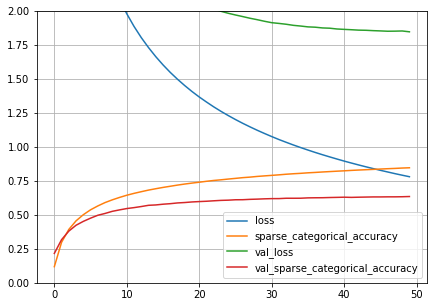

time: 164 ms (started: 2023-02-26 00:43:01 +00:00)


In [42]:
plot_loss(history2)

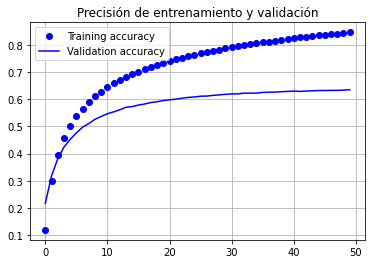

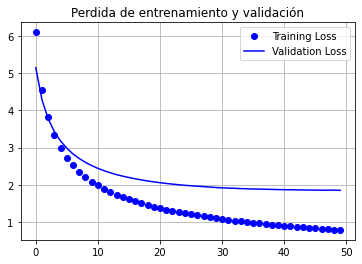

time: 259 ms (started: 2023-02-26 00:43:26 +00:00)


In [43]:
show_history(history2)

In [30]:
save_model(SIZE, TFM_PATH, custom_model2, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl9_imgs96_regular__OTSU.h5
time: 924 ms (started: 2023-02-25 20:29:47 +00:00)


# Imgs 112x112

- Test Accuracy: 0.6934232711791992
- Test Loss: 1.504781723022461
- time: 4h 7min 11s
- F1 score: 0.6944640556493837
- Precision score: 0.7139432493008758
- Recall:  0.6934232715008432
- Epoch: 50/50


## Cargar imágenes

In [31]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_112/splits/regular_otsu/
time: 680 µs (started: 2023-02-25 20:29:48 +00:00)


In [32]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 23.8 s (started: 2023-02-25 20:29:48 +00:00)


In [33]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 5.31 ms (started: 2023-02-25 20:30:11 +00:00)


## Preparar el modelo

In [34]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.96 s (started: 2023-02-25 20:30:12 +00:00)


In [35]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 118, 118, 3)  0          ['concatenate_2[0][0]']    

## Entrenar modelo


In [36]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 302s 21ms/step - loss: 5.7454 - sparse_categorical_accuracy: 0.1645 - val_loss: 4.6142 - val_sparse_categorical_accuracy: 0.2946
Epoch 2/50
13899/13899 [==============================] - 293s 21ms/step - loss: 3.9457 - sparse_categorical_accuracy: 0.3888 - val_loss: 3.6529 - val_sparse_categorical_accuracy: 0.4135
Epoch 3/50
13899/13899 [==============================] - 293s 21ms/step - loss: 3.1564 - sparse_categorical_accuracy: 0.4918 - val_loss: 3.1274 - val_sparse_categorical_accuracy: 0.4725
Epoch 4/50
13899/13899 [==============================] - 291s 21ms/step - loss: 2.6750 - sparse_categorical_accuracy: 0.5555 - val_loss: 2.7839 - val_sparse_categorical_accuracy: 0.5153
Epoch 5/50
13899/13899 [==============================] - 291s 21ms/step - loss: 2.3440 - sparse_categorical_accuracy: 0.6001 - val_loss: 2.5471 - val_sparse_categorical_accuracy: 0.5468
Epoch 6/50
13899/13899 [==============================] - 291s 21

## Métricas


In [37]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.82 s (started: 2023-02-26 00:37:27 +00:00)


In [38]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 35s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6934232711791992
- Test Loss: 1.504781723022461
- time: 
- F1 score: 0.6944640556493837
- Precision score: 0.7139432493008758
- Recall:  0.6934232715008432
- Epoch: 
*********************************************************************************************************************************
time: 1min 12s (started: 2023-02-26 00:37:32 +00:00)


## Graficando

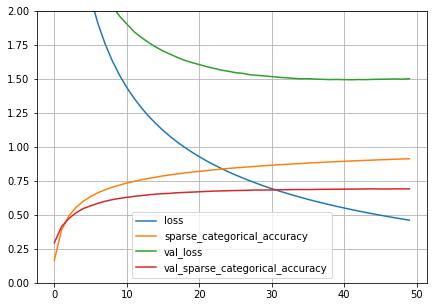

time: 157 ms (started: 2023-02-26 00:38:44 +00:00)


In [39]:
plot_loss(history)

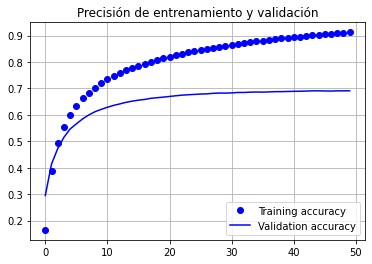

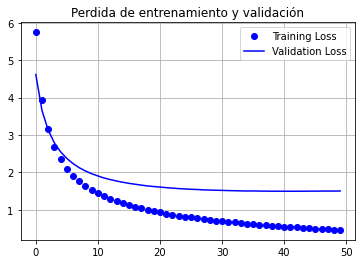

time: 250 ms (started: 2023-02-26 00:38:44 +00:00)


In [40]:
show_history(history)

In [41]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl9_imgs112_regular__OTSU.h5
time: 933 ms (started: 2023-02-26 00:38:45 +00:00)


# Imgs 127x127

- Test Accuracy: 0.7368296980857849
- Test Loss: 1.221299648284912
- time: 4h 23min 50s
- F1 score: 0.737881782348173
- Precision score: 0.7543904166679343
- Recall:  0.7368296795952782
- Epoch: 50/50



## Cargar imágenes

In [45]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_otsu/
time: 733 µs (started: 2023-02-26 00:45:11 +00:00)


In [46]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 29.5 s (started: 2023-02-26 00:45:11 +00:00)


In [47]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 898 µs (started: 2023-02-26 00:45:41 +00:00)


## Preparar el modelo

In [48]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 3.11 s (started: 2023-02-26 00:45:41 +00:00)


In [49]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 133, 133, 3)  0          ['concatenate_3[0][0]']    

## Entrenar modelo

In [50]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 351s 25ms/step - loss: 5.7285 - sparse_categorical_accuracy: 0.1801 - val_loss: 4.5207 - val_sparse_categorical_accuracy: 0.3240
Epoch 2/50
13899/13899 [==============================] - 320s 23ms/step - loss: 3.8176 - sparse_categorical_accuracy: 0.4269 - val_loss: 3.4705 - val_sparse_categorical_accuracy: 0.4558
Epoch 3/50
13899/13899 [==============================] - 306s 22ms/step - loss: 2.9780 - sparse_categorical_accuracy: 0.5345 - val_loss: 2.9031 - val_sparse_categorical_accuracy: 0.5234
Epoch 4/50
13899/13899 [==============================] - 304s 22ms/step - loss: 2.4751 - sparse_categorical_accuracy: 0.6005 - val_loss: 2.5421 - val_sparse_categorical_accuracy: 0.5662
Epoch 5/50
13899/13899 [==============================] - 303s 22ms/step - loss: 2.1364 - sparse_categorical_accuracy: 0.6451 - val_loss: 2.2960 - val_sparse_categorical_accuracy: 0.5960
Epoch 6/50
13899/13899 [==============================] - 303s 22

## Graficando

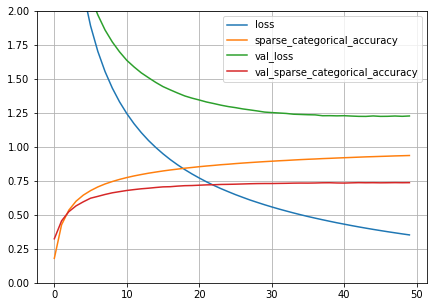

time: 145 ms (started: 2023-02-26 05:09:36 +00:00)


In [51]:
plot_loss(history)

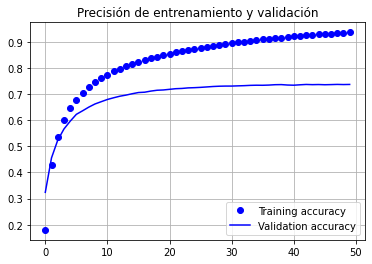

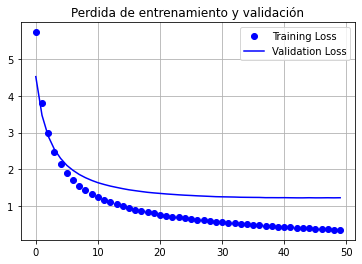

time: 243 ms (started: 2023-02-26 05:09:36 +00:00)


In [52]:
show_history(history)

In [53]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl9_imgs127_regular__OTSU.h5
time: 899 ms (started: 2023-02-26 05:09:36 +00:00)


## Métricas

In [54]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.92 s (started: 2023-02-26 05:09:37 +00:00)


In [55]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 36s 18ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7368296980857849
- Test Loss: 1.221299648284912
- time: 
- F1 score: 0.737881782348173
- Precision score: 0.7543904166679343
- Recall:  0.7368296795952782
- Epoch: 
*********************************************************************************************************************************
time: 1min 14s (started: 2023-02-26 05:09:42 +00:00)
